In [1]:
# Section 1: Imports
import time
from datetime import datetime
import re
from DrissionPage import errors
from DrissionPage import ChromiumPage
import mysql.connector
from mysql.connector import Error

def create_connection():
    try:
        connection = mysql.connector.connect(
            host='127.0.0.1',
            database='kol_1017',
            user='root',
            password='123456789',
            port=3306
        )
        if connection.is_connected():
            return connection
    except Error as e:
        print(f"Error while connecting to MySQL: {e}")
    return None

In [3]:
connection = create_connection()

if connection:
    cursor = connection.cursor()
    query = "SELECT COUNT(DISTINCT author) AS unique_authors FROM kol_post_detail;"
    cursor.execute(query)
    result = cursor.fetchone()
    print(f"唯一作者數量: {result[0]}")
    

    cursor.close()
    connection.close()


唯一作者數量: 105


C:\Users\SHI\AppData\Local\Temp\ipykernel_19088\3032112022.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  daily_posts = pd.read_sql(query_daily_posts, connection)


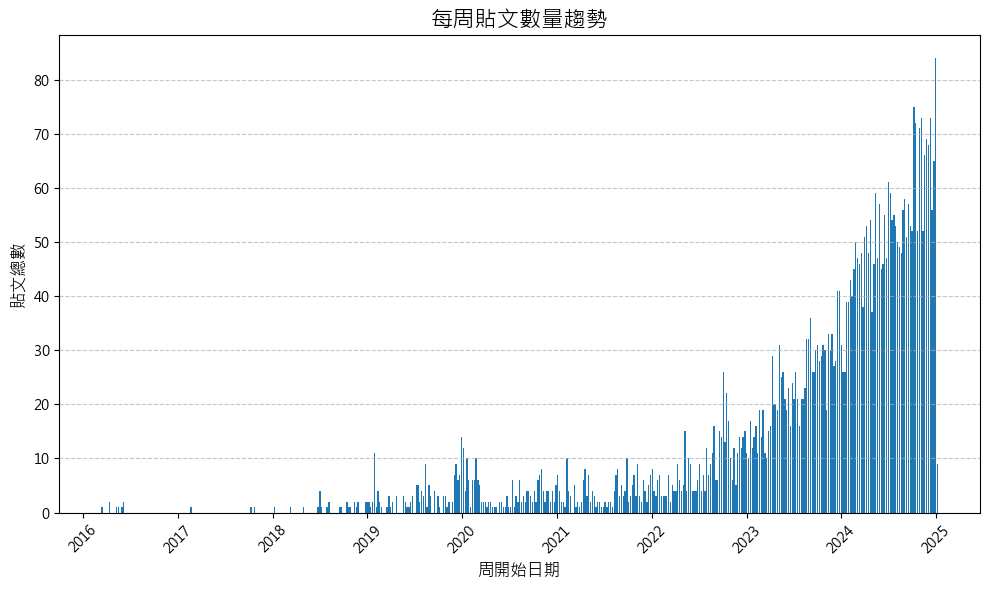

In [4]:
connection = create_connection()
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# 使用中文
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

if connection:
    query_daily_posts = """
    SELECT 
        DATE(post_time) AS post_date,
        COUNT(*) AS post_count
    FROM kol_post_detail
    GROUP BY DATE(post_time)
    ORDER BY post_date;
    """
    
    # 讀取資料
    daily_posts = pd.read_sql(query_daily_posts, connection)
    connection.close()  # 關閉資料庫連線

    # 確保日期列為日期型態
    daily_posts['post_date'] = pd.to_datetime(daily_posts['post_date'])

    # 新增一列表示每個日期所屬的周
    daily_posts['week'] = daily_posts['post_date'].dt.to_period('W').apply(lambda r: r.start_time)

    # 以周為單位計算貼文數量
    weekly_posts = daily_posts.groupby('week')['post_count'].sum().reset_index()

    # 重新命名欄位以便於理解
    weekly_posts.rename(columns={'week': '周開始日期', 'post_count': '貼文總數'}, inplace=True)

    # 繪製柱狀圖
    plt.figure(figsize=(10, 6))
    plt.bar(weekly_posts['周開始日期'], weekly_posts['貼文總數'], width=5, align='center')
    plt.title('每周貼文數量趨勢', fontsize=16)
    plt.xlabel('周開始日期', fontsize=12)
    plt.ylabel('貼文總數', fontsize=12)
    plt.xticks(rotation=45)  # 避免日期擠在一起
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()  # 自動調整佈局避免文字重疊
    plt.show()



C:\Users\SHI\AppData\Local\Temp\ipykernel_19088\2395309038.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, connection)


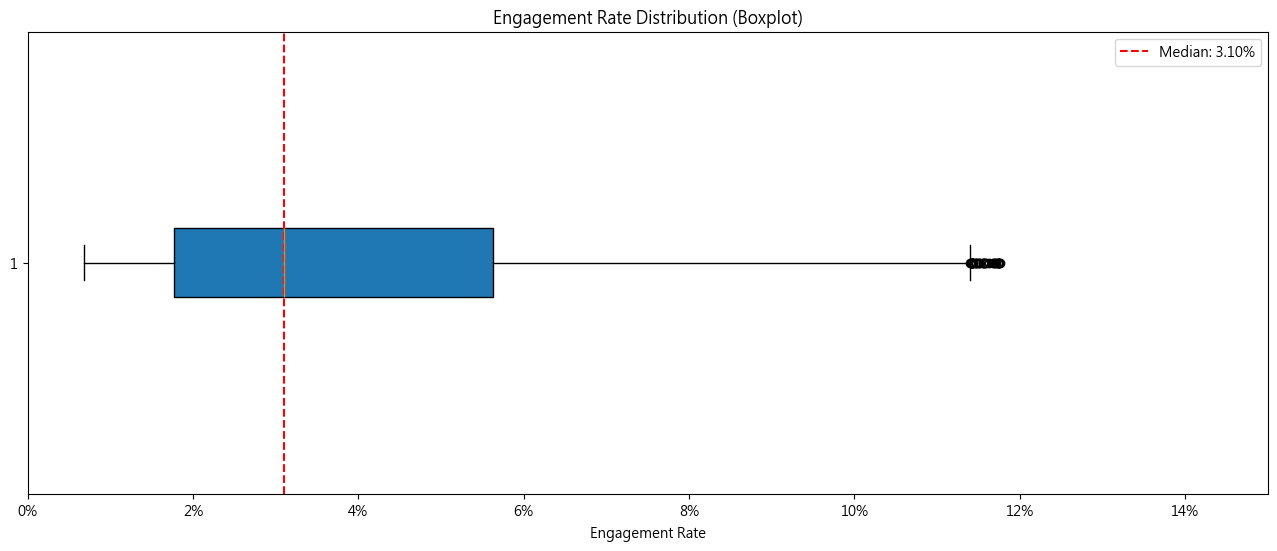

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# 步驟 1: 建立資料庫連線
connection = create_connection()  # 假設您已正確設定 create_connection 函數

# 步驟 2: 從資料庫讀取資料
query = "SELECT engagement_rate FROM kol_1017.kol_post_detail"
data = pd.read_sql(query, connection)

# 步驟 3: 清理資料
# 確保 engagement_rate 是數值類型，並移除無效值
data['engagement_rate'] = pd.to_numeric(data['engagement_rate'], errors='coerce')
cleaned_data = data.dropna(subset=['engagement_rate'])
#把頭尾的10%刪掉
cleaned_data = cleaned_data[(cleaned_data['engagement_rate'] > cleaned_data['engagement_rate'].quantile(0.1)) & (cleaned_data['engagement_rate'] < cleaned_data['engagement_rate'].quantile(0.9))]

# 步驟 4: 繪製盒形圖
plt.figure(figsize=(16, 6))
plt.boxplot(cleaned_data['engagement_rate'], vert=False, patch_artist=True)
#轉換成百分比
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
# 設定 x 軸範圍
xlim = plt.xlim(0,0.15)
#標記中位數以及其數值
median = cleaned_data['engagement_rate'].median()
#在圖上標記中位數
plt.axvline(median, color='r', linestyle='--', label=f'Median: {median:.2%}')
plt.legend()

plt.title('Engagement Rate Distribution (Boxplot)')
plt.xlabel('Engagement Rate')
plt.show()

# 可選步驟 5: 關閉資料庫連線
connection.close()


In [12]:
!pip install wordcloud jieba

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/00/09/abb305dce85911b8fba382926cfc57f2f257729e25937fdcc63f3a1a67f9/wordcloud-1.9.4-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/19.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/19.2 MB ? eta -:--:--
     --------------------------------------- 0.0/19.2 MB 217.9 kB/s eta 0:01:29
     --------------------------------------- 0.0/19.2 MB 326.8 kB/s eta 0:00:59
     --------------------------------------- 0.1/19.2 MB 521.8 kB/s eta 0:00:37
     --------------------------------------- 0.2/19.2 MB 857.5 kB/s eta 0:00:23
      --------------------------------------- 0.3/19.2 MB 1.1 MB/s eta 0:00:18
      --------------------------------------- 0.4/19.2 MB 1.4 MB/s eta 0:00:14
     - -------------------------------------- 0.7/19.2 MB 2.1 MB/s eta 0:00:09
     -- ------------------------------------- 1.3/19.2 MB 3.3 MB/s eta 0:00:06
     ---


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import mysql.connector
from mysql.connector import Error
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import jieba
from collections import Counter

# 抓取文章
def fetch_articles(connection):
    query = "SELECT article FROM kol_post_detail;"
    try:
        cursor = connection.cursor(dictionary=True)
        cursor.execute(query)
        records = cursor.fetchall()
        return [record['article'] for record in records if record['article']]  # 返回非空的文章列表
    except Error as e:
        print(f"Error while fetching data: {e}")
        return []

In [15]:
connection = create_connection()
if connection:
    articles = fetch_articles(connection)
    connection.close()
    print(f"Fetched {len(articles)} articles.")
    print(articles[:5])  # 顯示前 5 筆資料

Fetched 4977 articles.
['每一朵花都盛開於你的到來。\nEvery flower blooms upon your arrival.\n\n#插花#哈密瓜蛋糕#哈密瓜水果蛋糕#台中甜點#台中客製化蛋糕#台中#taichung#cantaloupe#鮮花蛋糕', 'Cyprus 玻璃海可以去無數次！\U0001fa75\U0001fa75\n#cyprus#塞普勒斯', '緣分很奇妙，我們在美國認識 都不是對方的國家，如果只差一點點，如果沒有雙向奔赴我們也不會走到一起，到現在兩年了，回想到第一次見面還覺得這一切真的太酷了💗\n生命中的不期而遇，都是生活中給予的驚喜🫶🏼', '🌤️\U0001fa75', '千萬人中 萬幸得以相逢💞 Best wishes everyone🐾']


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
import jieba

def extract_keywords(texts, top_n=20):
    vectorizer = TfidfVectorizer(max_features=top_n, stop_words=['的', '了', '是', '在', '也'])
    tfidf_matrix = vectorizer.fit_transform(texts)
    keywords = vectorizer.get_feature_names_out()
    return keywords

# 測試關鍵字提取
if articles:
    articles_cut = [' '.join(jieba.cut(article)) for article in articles]
    top_keywords = extract_keywords(articles_cut)
    print("Top Keywords:", top_keywords)


Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\SHI\AppData\Local\Temp\jieba.cache
Loading model cost 0.798 seconds.
Prefix dict has been built successfully.


Top Keywords: ['and' 'the' 'to' '一個' '什麼' '作文' '分享' '可以' '喜歡' '因為' '大家' '學測' '就是' '我們'
 '時間' '生活' '真的' '筆記' '自己' '英文']


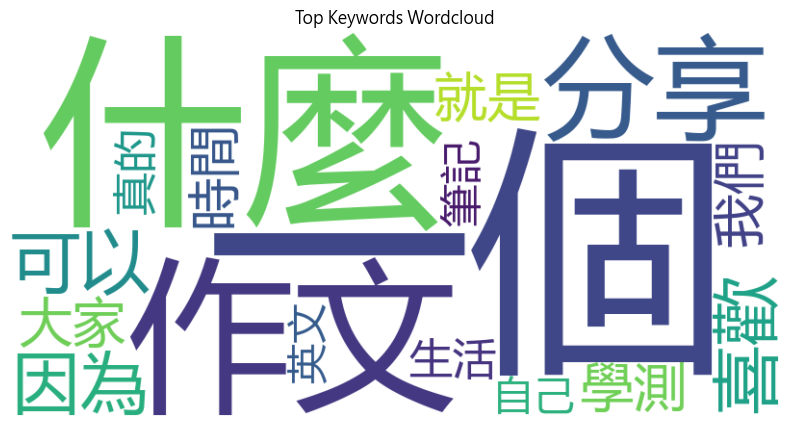

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(words):
    wordcloud = WordCloud(font_path='msyh.ttc', width=800, height=400, background_color='white').generate(' '.join(words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Top Keywords Wordcloud")
    plt.show()

# 測試詞雲生成
if articles:
    generate_wordcloud(top_keywords)


In [18]:
from collections import Counter

def analyze_high_frequency_words(articles, top_n=20):
    all_words = []
    for article in articles:
        all_words.extend(jieba.cut(article))
    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)

# 測試高頻詞分析
if articles:
    high_freq_words = analyze_high_frequency_words(articles)
    print("High Frequency Words:", high_freq_words)


High Frequency Words: [('\n', 63358), (' ', 46991), ('#', 23887), ('的', 21216), ('，', 16435), ('我', 6934), ('！', 5754), ('.', 5319), ('、', 4771), ('是', 4640), ('了', 4630), ('在', 4193), ('有', 3639), ('—', 3428), ('。', 3373), ('都', 3126), ('@', 3066), ('也', 3020), ('你', 2963), ('️', 2781)]


In [11]:

# 主函式
def main():
    # 建立資料庫連接
    connection = create_connection()
    if connection is None:
        return

    # 定義查詢語句
    query = "SELECT article FROM kol_post_detail;"  # 根據需要修改查詢語句

    # 抓取資料
    data = fetch_data_from_mysql(query, connection)
    if data is not None:
        print("Data fetched successfully.")
        print(data.head())  # 檢視前幾筆資料
        
    
    # 關閉連接
    connection.close()

if __name__ == "__main__":
    main()


Data fetched successfully.
   id                                          post_link       post_id  \
0   1  https://www.instagram.com/wu_11.16/p/C984CWESSKr/  wu_11.16_009   
1   2  https://www.instagram.com/wu_11.16/p/C84kzhPoOF7/  wu_11.16_011   
2   3  https://www.instagram.com/wu_11.16/p/C53WewUyjzD/  wu_11.16_012   
3   4  https://www.instagram.com/wu_11.16/p/C1EwxBnyl27/  wu_11.16_013   
4   5  https://www.instagram.com/wu_11.16/p/Cz3f5zDSeEi/  wu_11.16_014   

     author     cooperator                                            article  \
0  wu_11.16   sweetbb_food  每一朵花都盛開於你的到來。\nEvery flower blooms upon your a...   
1  wu_11.16                                 Cyprus 玻璃海可以去無數次！🩵🩵\n#cyprus#塞普勒斯   
2  wu_11.16  quincynetinho  緣分很奇妙，我們在美國認識 都不是對方的國家，如果只差一點點，如果沒有雙向奔赴我們也不會走到...   
3  wu_11.16                                                               🌤️🩵   
4  wu_11.16                                千萬人中 萬幸得以相逢💞 Best wishes everyone🐾   

                                         